#### <b>Download the Dataset</b>

* The dataset contains approximately 13,000 Korean "human face" images.
* In this dataset, all faces are cropped to a resolution of 128 X 128 pixels, although some of the original images have been high resolution.
* Each image filename indicates which family (household) number it belongs to.

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbMhBPnmIb5MutZvGicPKggBWKm5hLs0iwKfGW7_TwQIKg?download=1 -O custom_korean_family_dataset_resolution_128.zip
!unzip custom_korean_family_dataset_resolution_128.zip -d ./custom_korean_family_dataset_resolution_128

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [ ]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

#### <b>Family Relationship Dataset</b>

1. It consists of a total of 900 households and approximately exact 13,068 individuals.
2. The last part of the filename, such as "a1", indicates the "age group".
  * This dataset consists of 8 age group classes.
  * The task is one of the 8-classes classification problem.
  * If we perform random guessing, the accuracy is approximately 12.5%.
3. The age classification problem is somewhat challenging, thus, we expect that our dataset will be helpful for evaluating the forgetting performance of a machine unlearning algorithm.
  * Our proposed setting has been configured in a way that is almost similar to the NeurIPS Kaggle Competition 2023 held on Kaggle.
4. We have utilized "Family Relationship Dataset" from AI Hub for constructing this dataset.
  * <b>Link</b>: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=528

#### <b>Load Datasets</b>

* The following three datasets do not overlap at the household level.
  * Thus, our setting ensures any individual "subjects" are overlapped across the following three sub-dataset.
  * In other wrods, we set any person (subject) to do not simultaneously belonging to the $\mathcal{D}_{train}$, $\mathcal{D}_{test}$ and $\mathcal{D}_{unseen}$.
* <b>Training dataset $\mathcal{D}_{train}$</b>: (F0001 ~ F0299) folders have 10,025 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: (F0801 ~ F0850) folders have 1,539 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: (F0851 ~ F0900) folders have 1,504 images.

In [ ]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""
def parsing(meta_data):
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [ ]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget=False, retain=False):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # Process the metadata.
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

        # After training the original model, we will do "machine unlearning".
        # The machine unlearning requires two datasets, ① forget dataset and ② retain dataset.
        # In this experiment, we set the first 1,500 images to be forgotten and the rest images to be retained.
        if forget:
            self.image_age_list = self.image_age_list[:1500]
        if retain:
            self.image_age_list = self.image_age_list[1500:]

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

unseen_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
unseen_meta_data = pd.read_csv(unseen_meta_data_path)
unseen_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

unseen_dataset = Dataset(unseen_meta_data, unseen_image_directory, unseen_transform)
unseen_dataloader = DataLoader(unseen_dataset, batch_size=64, shuffle=False)

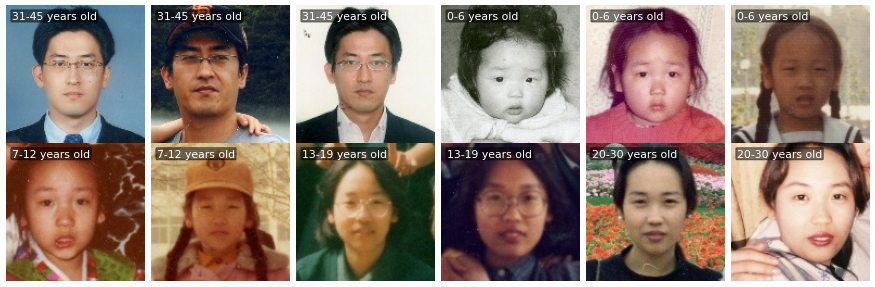

In [ ]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_to_age[label.item()] for label in labels[7:19]]

show_images(imgs[7:19], label_strs, nrow=6)

In [ ]:
@torch.no_grad()
def evaluation(model, data_loader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    running_top2_corrects = 0
    log_step = 20

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)  # Get the top 2 class indices.
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, y in loader:
        targets = y
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)

        losses = criterion(logits, targets).cpu().detach().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):
    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

#### <b>Load the Pre-trained Original Model</b>

* We can easily download the pre-trained original model, rather than training the original model from scratch.
* <b>Download Link</b>: https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNlaO0X8_1Ij4WPPLs09cgBQl3WB_y7zNTNwvRvIn2CDg

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNlaO0X8_1Ij4WPPLs09cgBQl3WB_y7zNTNwvRvIn2CDg?download=1 -O pre_trained_last_checkpoint_epoch_30.pth

--2023-10-30 17:21:26--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNlaO0X8_1Ij4WPPLs09cgBQl3WB_y7zNTNwvRvIn2CDg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_30.pth?ga=1 [following]
--2023-10-30 17:21:27--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_30.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 44803358 (43M) [application/octet-stream]
Saving to: ‘pre_trained_last_checkpoint_epoch_30.pth’

pre_trained_last_ch 10

#### <b>Machine Unlearning Experiments</b>

* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.

In [ ]:
forget_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, forget=True)
forget_dataloader_train = DataLoader(forget_dataset_train, batch_size=64, shuffle=True)

retain_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, retain=True)
retain_dataloader_train = DataLoader(retain_dataset_train, batch_size=64, shuffle=True)

forget_dataset_test = Dataset(train_meta_data, train_image_directory, test_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=64, shuffle=False)

retain_dataset_test = Dataset(train_meta_data, train_image_directory, test_transform, retain=True)
retain_dataloader_test = DataLoader(retain_dataset_test, batch_size=64, shuffle=False)

In [ ]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Forget dataset size:', len(forget_dataset_train))
print('Retain dataset size:', len(retain_dataset_train))
print('Unseen dataset size:', len(unseen_dataset))

Train dataset size: 10025
Test dataset size: 1539
Forget dataset size: 1500
Retain dataset size: 8525
Unseen dataset size: 1504


In [ ]:
# Checking for duplicates across datasets
train_image_paths = [x[0] for x in train_dataset.image_age_list]
test_image_paths = [x[0] for x in test_dataset.image_age_list]
forget_image_paths = [x[0] for x in forget_dataset_train.image_age_list]
retain_image_paths = [x[0] for x in retain_dataset_train.image_age_list]
unseen_image_paths = [x[0] for x in unseen_dataset.image_age_list]

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 1500,
 'train_retain': 8525,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

<b>Original Model Preformance</b>

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
original_model = models.resnet18(pretrained=False)
num_features = original_model.fc.in_features
original_model.fc = nn.Linear(num_features, 8)
original_model.load_state_dict(torch.load(original_save_path))
original_model = original_model.cuda()
criterion = nn.CrossEntropyLoss()

test_acc = evaluation(original_model, test_dataloader)
test_acc

set_seed(42)

# Performance
test_acc = evaluation(original_model, test_dataloader)
unseen_acc = evaluation(original_model, unseen_dataloader)
mia = cal_mia(original_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

last_checkpoint_epoch_30.pth
[Test]
[Batch: 1] running test loss: 0.02325533702969551, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
test loss: 0.026779032899932168, accuracy: 0.5951916829109811, top-2 accuracy: 0.8804418453541261
elapsed time: 2.485352039337158
[Test]
[Batch: 1] running test loss: 0.02325533702969551, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
test loss: 0.026779032899932168, accuracy: 0.5951916829109811, top-2 accuracy: 0.8804418453541261
elapsed time: 1.5991742610931396
[Test]
[Batch: 1] running test loss: 0.019372565671801567, running test accuracy: 0.640625, running top-2 accuracy: 0.9375
test loss: 0.021540874337896386, accuracy: 0.65625, top-2 accuracy: 0.8936170212765957
elapsed time: 1.569807767868042

Test Acc: {'Loss': 0.026779032899932168, 'Acc': 0.5951916829109811, 'Top-2 Acc': 0.8804418453541261}
Unseen Acc: {'Loss': 0.021540874337896386, 'Acc': 0.65625, 'Top-2 Acc': 0.8936170212765957}
MIA: {'MIA': 0.7136212624584718,

#### <b>UNSIR</b>
* <b>Impair phase (Stage 1)</b>: Update noise to increase the distance between the model and the forget dataset. Then, the updated noise is then integrated into the training dataset to enhance the model's ability to forget the specific dataset.
* <b>Repair phase (Stage 2)</b>: Repair the impaired model using the retain dataset.

<b> Stage1: Impair</b>

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
unlearned_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

test_acc = evaluation(unlearned_model, test_dataloader)
test_acc

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Test]
[Batch: 1] running test loss: 0.02325533702969551, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
test loss: 0.026779032899932168, accuracy: 0.5951916829109811, top-2 accuracy: 0.8804418453541261
elapsed time: 2.68072247505188


{'Loss': 0.026779032899932168,
 'Acc': 0.5951916829109811,
 'Top-2 Acc': 0.8804418453541261}

In [ ]:
class Noise(nn.Module):
    def __init__(self, batch_size, *dim):
        super().__init__()
        self.noise = nn.Parameter(torch.randn(batch_size, *dim), requires_grad=True)

    def forward(self):
        return self.noise

def float_to_uint8(img_float):
    """Convert a floating point image in the range [0,1] to uint8 image in the range [0,255]."""
    img_uint8 = (img_float * 255).astype(np.uint8)
    return img_uint8

In [ ]:
set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

print_interval = 1
train_epoch_losses = []

num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, ((x_retain, y_retain), (x_forget, y_forget)) in enumerate(zip(retain_dataloader_train, forget_dataloader_train)):
        y_retain = y_retain.cuda()
        batch_size_forget = y_forget.size(0)

        if x_retain.size(0) != 64 or x_forget.size(0) != 64:
            continue

        # Initialize the noise.
        noise_dim = x_retain.size(1), x_retain.size(2), x_retain.size(3)
        noise = Noise(batch_size_forget, *noise_dim).cuda()
        noise_optimizer = torch.optim.Adam(noise.parameters(), lr=0.01)
        noise_tensor = noise()[:batch_size_forget]

        # Update the noise for increasing the loss value.
        for _ in range(5):
            outputs = unlearned_model(noise_tensor)
            with torch.no_grad():
                target_logits = unlearned_model(x_forget.cuda())
            # Maximize the similarity between noise data and forget features.
            loss_noise = -F.mse_loss(outputs, target_logits)

            # Backpropagate to update the noise.
            noise_optimizer.zero_grad()
            loss_noise.backward(retain_graph=True)
            noise_optimizer.step()

        # Train the model with noise and retain image
        noise_tensor = torch.clamp(noise_tensor, 0, 1).detach().cuda()
        outputs = unlearned_model(noise_tensor.cuda())
        loss_1 = criterion(outputs, y_retain)

        outputs = unlearned_model(x_retain.cuda())
        loss_2 = criterion(outputs, y_retain)

        joint_loss = loss_1 + loss_2

        optimizer.zero_grad()
        joint_loss.backward()
        optimizer.step()
        running_loss += joint_loss.item() * x_retain.size(0)

        original_image = x_retain[0].cpu().numpy().transpose(1, 2, 0)
        image1 = TF.to_pil_image(float_to_uint8(original_image))
        image2 = TF.to_pil_image(noise.noise[0].cpu())

        # Display original image.
        original_image = x_retain[0].cpu().numpy().transpose(1, 2, 0)
        plt.figure(figsize=(12, 8))
        plt.subplot(1, 2, 1)  # 2 rows, 2 columns, position 1
        plt.imshow(image1)
        plt.title("Original Image")
        plt.axis('off')

        # Display first noise image.
        plt.subplot(1, 2, 2)
        plt.imshow(image2)
        plt.title("Noise Image")
        plt.axis('off')

        # Show all the subplots.
        plt.tight_layout()
        plt.show()

        if batch_idx % print_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {joint_loss.item():.4f}")

    average_train_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    train_epoch_losses.append(average_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {average_train_loss:.4f}")

In [ ]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.021168405190110207, running test accuracy: 0.59375, running top-2 accuracy: 0.921875
test loss: 0.02465548315475791, accuracy: 0.5828460038986355, top-2 accuracy: 0.8700454840805718
elapsed time: 1.9904470443725586
[Test]
[Batch: 1] running test loss: 0.018128544092178345, running test accuracy: 0.640625, running top-2 accuracy: 0.96875
test loss: 0.020391520231645158, accuracy: 0.636968085106383, top-2 accuracy: 0.8882978723404256
elapsed time: 2.4130935668945312

Test Acc: {'Loss': 0.02465548315475791, 'Acc': 0.5828460038986355, 'Top-2 Acc': 0.8700454840805718}
Unseen Acc: {'Loss': 0.020391520231645158, 'Acc': 0.636968085106383, 'Top-2 Acc': 0.8882978723404256}
MIA: {'MIA': 0.7179401993355482, 'Forgeting Score': 0.2179401993355482}
Final Score: 0.5734828026137695


<b>Stage 2: Repair</b>

In [ ]:
set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        # Classification Loss
        outputs_retain = unlearned_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()

        running_loss += classification_loss.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

Epoch [1/1], Batch [1/134] - Batch Loss: 0.0891
Epoch [1/1], Batch [2/134] - Batch Loss: 0.0648
Epoch [1/1], Batch [3/134] - Batch Loss: 0.1883
Epoch [1/1], Batch [4/134] - Batch Loss: 0.1206
Epoch [1/1], Batch [5/134] - Batch Loss: 0.1596
Epoch [1/1], Batch [6/134] - Batch Loss: 0.0826
Epoch [1/1], Batch [7/134] - Batch Loss: 0.1842
Epoch [1/1], Batch [8/134] - Batch Loss: 0.1489
Epoch [1/1], Batch [9/134] - Batch Loss: 0.1816
Epoch [1/1], Batch [10/134] - Batch Loss: 0.0751
Epoch [1/1], Batch [11/134] - Batch Loss: 0.1748
Epoch [1/1], Batch [12/134] - Batch Loss: 0.2111
Epoch [1/1], Batch [13/134] - Batch Loss: 0.0502
Epoch [1/1], Batch [14/134] - Batch Loss: 0.1859
Epoch [1/1], Batch [15/134] - Batch Loss: 0.0946
Epoch [1/1], Batch [16/134] - Batch Loss: 0.1582
Epoch [1/1], Batch [17/134] - Batch Loss: 0.1294
Epoch [1/1], Batch [18/134] - Batch Loss: 0.0667
Epoch [1/1], Batch [19/134] - Batch Loss: 0.1255
Epoch [1/1], Batch [20/134] - Batch Loss: 0.0846
Epoch [1/1], Batch [21/134] -

In [ ]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.022762473672628403, running test accuracy: 0.640625, running top-2 accuracy: 0.90625
test loss: 0.026868395018376182, accuracy: 0.5906432748538012, top-2 accuracy: 0.8654970760233918
elapsed time: 1.7470817565917969
[Test]
[Batch: 1] running test loss: 0.017462819814682007, running test accuracy: 0.703125, running top-2 accuracy: 0.96875
test loss: 0.02197443388719508, accuracy: 0.6349734042553191, top-2 accuracy: 0.870345744680851
elapsed time: 1.8268036842346191

Test Acc: {'Loss': 0.026868395018376182, 'Acc': 0.5906432748538012, 'Top-2 Acc': 0.8654970760233918}
Unseen Acc: {'Loss': 0.02197443388719508, 'Acc': 0.6349734042553191, 'Top-2 Acc': 0.870345744680851}
MIA: {'MIA': 0.7049833887043191, 'Forgeting Score': 0.2049833887043191}
Final Score: 0.5903382487225814
